<a href="https://colab.research.google.com/github/putrinahampun/StartupCampusJourney/blob/main/Practices/pytorch_cifar100_multiclassif_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch, torchvision, time
from numpy.random import seed
from numpy import transpose
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from warnings import filterwarnings as fw; fw("ignore")

<ipython-input-2-05a2c0b08704>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# UDFs

In [3]:
def imshow(img : torch.Tensor, *args, **kwargs) -> None:
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

* Define seedings

In [5]:
# untuk mengacak data biar random (?)
# untuk CPU
seed(0)
torch.manual_seed(0)

SEED = 0 #bebas diisi berapa angka ga ada aturannya
# kalo untukk GPU
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

* Set hyperparameters

In [6]:
# parameter yang nilai nya bakalan dipakek buat pembelajaran
# bekerja sebagai controller dalam pembelajaran neural network
EPOCH = 10
BATCH_SIZE = 16
LEARNING_RATE = 3E-3 #equals to 0.003

* Data augmentation template

In [7]:
# stats = ((0.5,0.5,0.5),(0.5,0.5,0.5)) => kalo ga tau nilai stats nya
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
data_transform = torchvision.transforms.Compose([
    # dieksekusi didalam memori, jadi bukan berarti data gambar nya bertambah
    torchvision.transforms.RandomRotation(20), # between (-20,20) degree
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*stats, inplace=True)
])

* Download and split MNIST datasets

In [8]:
# Training and Validation sets
train_dataset = torchvision.datasets.CIFAR100(root=".",train=True, download=True, transform=data_transform)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,[40000,10000])

# Test sets
test_dataset = torchvision.datasets.CIFAR100(root=".",train=False, download=True, transform=data_transform)

# DATALOADER  --> assign raw datasets into mini-batches
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 169001437/169001437 [00:02<00:00, 79857450.92it/s]


Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


In [9]:
print("Total TRAIN dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch." \
      .format(len(train_dataset), len(train_loader), BATCH_SIZE))

Total TRAIN dataset: 40000.
For mini-batch settings, there will be 2500 batches, with 16 data for each batch.


In [10]:
print("Total VALIDATION dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch." \
      .format(len(valid_dataset), len(valid_loader), BATCH_SIZE))

Total VALIDATION dataset: 10000.
For mini-batch settings, there will be 625 batches, with 16 data for each batch.


In [11]:
print("Total TEST dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch." \
      .format(len(test_dataset), len(test_loader), BATCH_SIZE))

Total TEST dataset: 10000.
For mini-batch settings, there will be 625 batches, with 16 data for each batch.


* Show some images

In [12]:
cifar100_label_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', \
    'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', \
    'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', \
    'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', \
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', \
    'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', \
    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', \
    'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', \
    'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', \
    'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', \
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

CIFAR100 = (60000, 32, 32, 3)

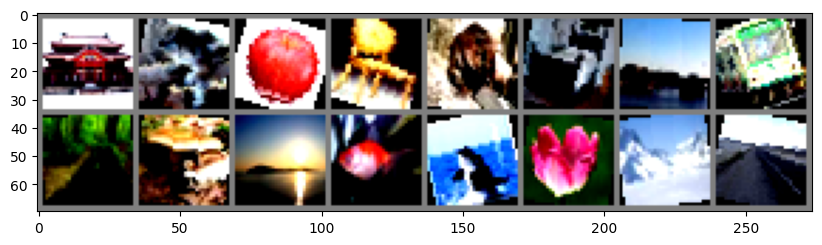



LABELS (from left to right): 
castle,squirrel,apple,chair,beaver,bed,bridge,streetcar,forest,mushroom,sea,aquarium_fish,whale,tulip,mountain,road


In [13]:
# untuk melihat data gambar
dataiter = iter(train_loader)
images, labels = next(dataiter)

# hasil gambar kelihatan berotasi karna pengaruh data augmentation.
imshow(img=torchvision.utils.make_grid(images))
print('\n')
print("LABELS (from left to right): \n{}".format(",".join([cifar100_label_names[i] for i in labels])))

### Define the model class (template)

In [14]:
class ConvNetSC5(torch.nn.Module):
  def __init__(self, n_class: int, *args, **kwargs) -> None:
    super(ConvNetSC5, self).__init__()
    self.n_class = n_class

    # feature extractor (Convolutional Neural Network)
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3)
    self.conv2 = torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3)

      # Maxpooling
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=1) #stride itu pergeseran kotak2 pas maxpooling
    self.GlobalAvgPooling = torch.nn.AdaptiveAvgPool2d(output_size=(1,1))

    # Classifier (Perceptron/Simple ANN)
    self.fc1 = torch.nn.Linear(in_features=128, out_features=self.n_class)

  def forward(self,data,*args,**kwargs) -> torchvision.models:
    # x = self.conv1(data) => simpan dulu ke x hasil konvolusi
    # x = torch.nn.functional.relu(x) => trus gunakan relu function
    # x = self.pool(x) => baru maxpooling

    x = self.pool(torch.nn.functional.relu(self.conv1(data)))
    x = self.pool(torch.nn.functional.relu(self.conv2(x)))
    x = self.GlobalAvgPooling(x)
    x = torch.flatten(x,1) #flatten all dimension EXCEPT batch

    x = self.fc1(x)
    return x

* Set the device: **CUDA®** (Compute Unified Device Architecture)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# kalau device="cuda" (GPU), baik MODEL + DATASET juga harus di GPU.
# jadi tidak bisa model di CPU, dan dataset di GPU, atau sebaliknya

device(type='cuda')

* Call the model

In [16]:
model = ConvNetSC5(n_class=100).to(device)
model

ConvNetSC5(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (GlobalAvgPooling): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=100, bias=True)
)

* Set loss function

In [17]:
loss_function = torch.nn.CrossEntropyLoss() #karna multiclassification

* Set optimizer

In [18]:
# pakek Adam dulu
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Start model training

* Training and validation phases

In [19]:
TRAIN_LOSS, TRAIN_ACC = [], []
train_batches = len(train_loader)

VAL_LOSS, VAL_ACC = [], []
val_batches = len(valid_loader)

# loop for every epoch (training + evaluation)
start_ts = time.time()
for e in range(EPOCH):
    train_losses = 0
    train_accuracies = 0

    # ----------------- TRAINING  --------------------
    model.train()

    for i, data in enumerate(train_loader):
      X = data[0].to(device) #image
      y = data[1].to(device) #label

      # training step for single batch
      model.zero_grad() #zero gradient

      # forward pass => find errors
      outputs = model(X)
      loss = loss_function(outputs, y)

      # backward pass =? update weights and biases
      loss.backward()
      optimizer.step()

      train_losses += loss.item()

      # measure accuracy
      ps = torch.exp(outputs)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == y.view(*top_class.shape)
      train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()


    TRAIN_ACC.append(train_accuracies/train_batches)
    TRAIN_LOSS.append(train_losses/train_batches)

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

    # ----------------- VALIDATION  -----------------
    val_losses = 0
    val_accuracies = 0

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(valid_loader):
        X = data[0].to(device) #images
        y = data[1].to(device) #labels

        outputs = model(X)
        val_losses += loss_function(outputs, y).item()

        # measure accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

    print("Epoch {}/{}".format(e+1, EPOCH))
    print("Training loss: {:.3f}, accuracy: {:.3f}%".format(train_losses/train_batches, train_accuracies/train_batches*100))
    print("Validation loss: {:.3f}, accuracy: {:.3f}%".format(val_losses/val_batches, val_accuracies/val_batches*100))
    print()

    VAL_ACC.append(val_accuracies/val_batches)
    VAL_LOSS.append(val_losses/val_batches)

tr_time = time.time()-start_ts
print("Training time: {:.3f}s".format(tr_time))

Epoch 1/10
Training loss: 4.156, accuracy: 6.087%
Validation loss: 3.934, accuracy: 8.940%

Epoch 2/10
Training loss: 3.872, accuracy: 9.997%
Validation loss: 3.767, accuracy: 11.130%

Epoch 3/10
Training loss: 3.770, accuracy: 11.412%
Validation loss: 3.780, accuracy: 10.970%

Epoch 4/10
Training loss: 3.711, accuracy: 12.420%
Validation loss: 3.667, accuracy: 12.870%

Epoch 5/10
Training loss: 3.667, accuracy: 13.020%
Validation loss: 3.634, accuracy: 13.350%

Epoch 6/10
Training loss: 3.634, accuracy: 13.667%
Validation loss: 3.578, accuracy: 13.550%

Epoch 7/10
Training loss: 3.612, accuracy: 13.715%
Validation loss: 3.585, accuracy: 14.000%

Epoch 8/10
Training loss: 3.586, accuracy: 14.140%
Validation loss: 3.591, accuracy: 14.100%

Epoch 9/10
Training loss: 3.566, accuracy: 14.172%
Validation loss: 3.543, accuracy: 14.600%

Epoch 10/10
Training loss: 3.532, accuracy: 15.100%
Validation loss: 3.485, accuracy: 16.140%

Training time: 336.303s


* Load model and predict (test)

In [22]:
torch.save(model.state_dict(), "./my_first_model.pt")

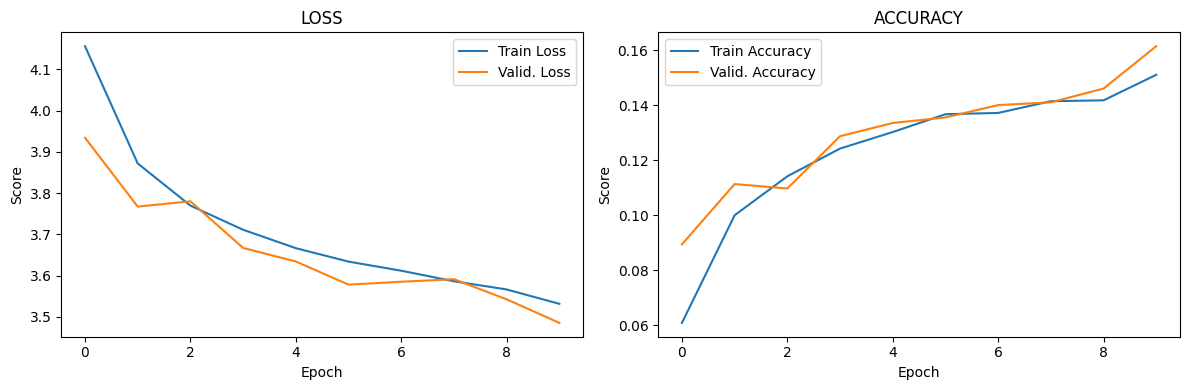

In [21]:
plot_performance({
    "train_acc": TRAIN_ACC,
    "train_loss": TRAIN_LOSS,
    "val_acc": VAL_ACC,
    "val_loss": VAL_LOSS
})